In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import missingno as msno
import matplotlib.pyplot as plt
import warnings
from utils import get_spi_from_precip_col
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
%matplotlib inline


dataset = 'Data/Little-River-SCAN-2008-2017.csv'
label_set = labels_set = 'Data/header_descriptions.csv'
labels = pd.read_csv(labels_set)
df = pd.read_csv(dataset)

In [44]:
df

,Site Id,Date,PREC.I-1 (in),TOBS.I-1 (degC),TMAX.D-1 (degC),TMIN.D-1 (degC),TAVG.D-1 (degC),SMS.I-1:-2 (pct) (loam),SMS.I-1:-4 (pct) (loam),SMS.I-1:-8 (pct) (loam),...,RDC.I-1:-2 (unit),RDC.I-1:-4 (unit),RDC.I-1:-8 (unit),RDC.I-1:-20 (unit),RDC.I-5:-40 (unit),BATT.I-1 (volt),BATT.I-2 (volt),WDIRV.D-1 (degr),WSPDV.D-1 (mph),PRCP
0,2027,2008-11-01,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,...,6.00,5.90,7.00,7.70,14.80,13.39,3.32,63.0,2.8,0.0
1,2027,2008-11-02,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,...,6.00,5.80,6.80,7.60,14.80,13.37,3.32,92.0,2.1,0.0
2,2027,2008-11-03,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,...,5.90,5.70,6.80,7.60,14.70,13.35,3.33,98.0,2.0,0.0
3,2027,2008-11-04,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,...,5.90,5.70,6.60,7.40,14.70,13.30,3.33,82.0,5.3,0.0
4,2027,2008-11-05,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,...,5.80,5.60,6.60,7.50,14.50,13.32,3.33,74.0,4.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,2027,2017-11-27,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,...,5.42,5.70,6.55,6.18,15.13,12.85,3.24,345.0,3.7,0.0
3137,2027,2017-11-28,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,...,5.26,5.62,6.78,5.99,15.29,12.87,3.22,75.0,1.8,0.0
3138,2027,2017-11-29,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,...,5.09,5.62,6.54,6.17,15.22,12.88,3.22,83.0,2.8,0.0
3139,2027,2017-11-30,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,...,5.20,5.52,6.29,6.01,15.01,12.87,3.24,54.0,2.3,0.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Id                    3141 non-null   int64  
 1   Date                       3141 non-null   object 
 2   PREC.I-1 (in)              2980 non-null   float64
 3   TOBS.I-1 (degC)            3073 non-null   float64
 4   TMAX.D-1 (degC)            3065 non-null   float64
 5   TMIN.D-1 (degC)            3062 non-null   float64
 6   TAVG.D-1 (degC)            3062 non-null   float64
 7   SMS.I-1:-2 (pct)  (loam)   3070 non-null   float64
 8   SMS.I-1:-4 (pct)  (loam)   3074 non-null   float64
 9   SMS.I-1:-8 (pct)  (loam)   2536 non-null   float64
 10  SMS.I-1:-20 (pct)  (loam)  3071 non-null   float64
 11  SMS.I-5:-40 (pct)  (loam)  3072 non-null   float64
 12  STO.I-1:-2 (degC)          3074 non-null   float64
 13  STO.I-1:-4 (degC)          3074 non-null   float

In [46]:
# Split DateTime Col
def make_date_cols(dFrame) :
    date_splits = [
    ('year', 0 , 4), ('month', 5, 7), ('day', 8,10)
    ]
    for i in date_splits:
        dFrame[i[0]] = [d[i[1]:i[2]] for d in dFrame['Date']]
    return dFrame
df = make_date_cols(df)

In [47]:
df.year.value_counts().sort_values(ascending=True)

2008     54
2010    318
2017    327
2012    331
2014    340
2009    342
2011    353
2013    356
2016    359
2015    361
Name: year, dtype: int64

In [48]:
# Get how many duplicated days we have
def get_dup_subset(dFrame):
    return dFrame.loc[dFrame.duplicated(subset=['Date'], keep=False), :]
print(f'Duplicated Days: {get_dup_subset(df).shape[0]}')

Duplicated Days: 18


In [49]:
# Merge Duplicates
df = df.groupby('Date').mean().reset_index()
# Remove duplicates
df.drop_duplicates(subset=['Date'], inplace=True)
# Check our work
print(f'Duplicated Days: {get_dup_subset(df).shape[0]}')

Duplicated Days: 0


In [50]:
df = make_date_cols(df)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Site Id,PREC.I-1 (in),TOBS.I-1 (degC),TMAX.D-1 (degC),TMIN.D-1 (degC),TAVG.D-1 (degC),SMS.I-1:-2 (pct) (loam),SMS.I-1:-4 (pct) (loam),SMS.I-1:-8 (pct) (loam),...,RDC.I-1:-20 (unit),RDC.I-5:-40 (unit),BATT.I-1 (volt),BATT.I-2 (volt),WDIRV.D-1 (degr),WSPDV.D-1 (mph),PRCP,year,month,day
0,2008-11-01,2027.0,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,...,7.70,14.80,13.39,3.32,63.0,2.8,0.0,2008,11,01
1,2008-11-02,2027.0,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,...,7.60,14.80,13.37,3.32,92.0,2.1,0.0,2008,11,02
2,2008-11-03,2027.0,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,...,7.60,14.70,13.35,3.33,98.0,2.0,0.0,2008,11,03
3,2008-11-04,2027.0,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,...,7.40,14.70,13.30,3.33,82.0,5.3,0.0,2008,11,04
4,2008-11-05,2027.0,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,...,7.50,14.50,13.32,3.33,74.0,4.5,0.0,2008,11,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,2017-11-27,2027.0,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,...,6.18,15.13,12.85,3.24,345.0,3.7,0.0,2017,11,27
3128,2017-11-28,2027.0,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,...,5.99,15.29,12.87,3.22,75.0,1.8,0.0,2017,11,28
3129,2017-11-29,2027.0,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,...,6.17,15.22,12.88,3.22,83.0,2.8,0.0,2017,11,29
3130,2017-11-30,2027.0,3.18,14.5,26.7,12.7,17.4,7.0,7.7,9.4,...,6.01,15.01,12.87,3.24,54.0,2.3,0.0,2017,11,30


In [51]:
def custom_labeler(dFrame):
    labels.drop([0], inplace=True)
    colsMap = {}
    def labelGen(label):
        row = labels.loc[labels['Label'] == label, :].iloc[0]
        temp = f'{row.Element} {row["Sensor Height"]} ({row.Unit})'
        temp = temp.replace('nan', '')
        return temp.strip()
    cols_string = ",".join(dFrame.columns[1:-3])
    replacements = ['(degC)','(pct)','(loam)','(gram)','(unit)','(volt)', '(degr)','(in)','(mph)']
    for i in replacements:
        cols_string = cols_string.replace(i, '')

    cols_list = [i.strip() for i in cols_string.split(',')]

    zipped_cols = dict(zip(list(dFrame.columns[1:-3]), cols_list))

    for i in list(labels.Label):
        colsMap[i] = labelGen(i)


    return dFrame.rename(columns=zipped_cols).rename(columns=colsMap)


labeled_df = custom_labeler(df.copy())
labeled_df.set_index(['Date'], inplace=True)
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3132 entries, 2008-11-01 to 2017-12-01
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Site Id                                3132 non-null   float64
 1   Precipitation Accumulation  (In)       2972 non-null   float64
 2   Air Temperature Observed  (Degc)       3073 non-null   float64
 3   Air Temperature Maximum  (Degc)        3065 non-null   float64
 4   Air Temperature Minimum  (Degc)        3062 non-null   float64
 5   Air Temperature Average  (Degc)        3062 non-null   float64
 6   Soil Moisture Percent -2" (Pct)        3070 non-null   float64
 7   Soil Moisture Percent -4" (Pct)        3074 non-null   float64
 8   Soil Moisture Percent -8" (Pct)        2536 non-null   float64
 9   Soil Moisture Percent -20" (Pct)       3071 non-null   float64
 10  Soil Moisture Percent -40" (Pct)       3072 non-null  

<AxesSubplot:>

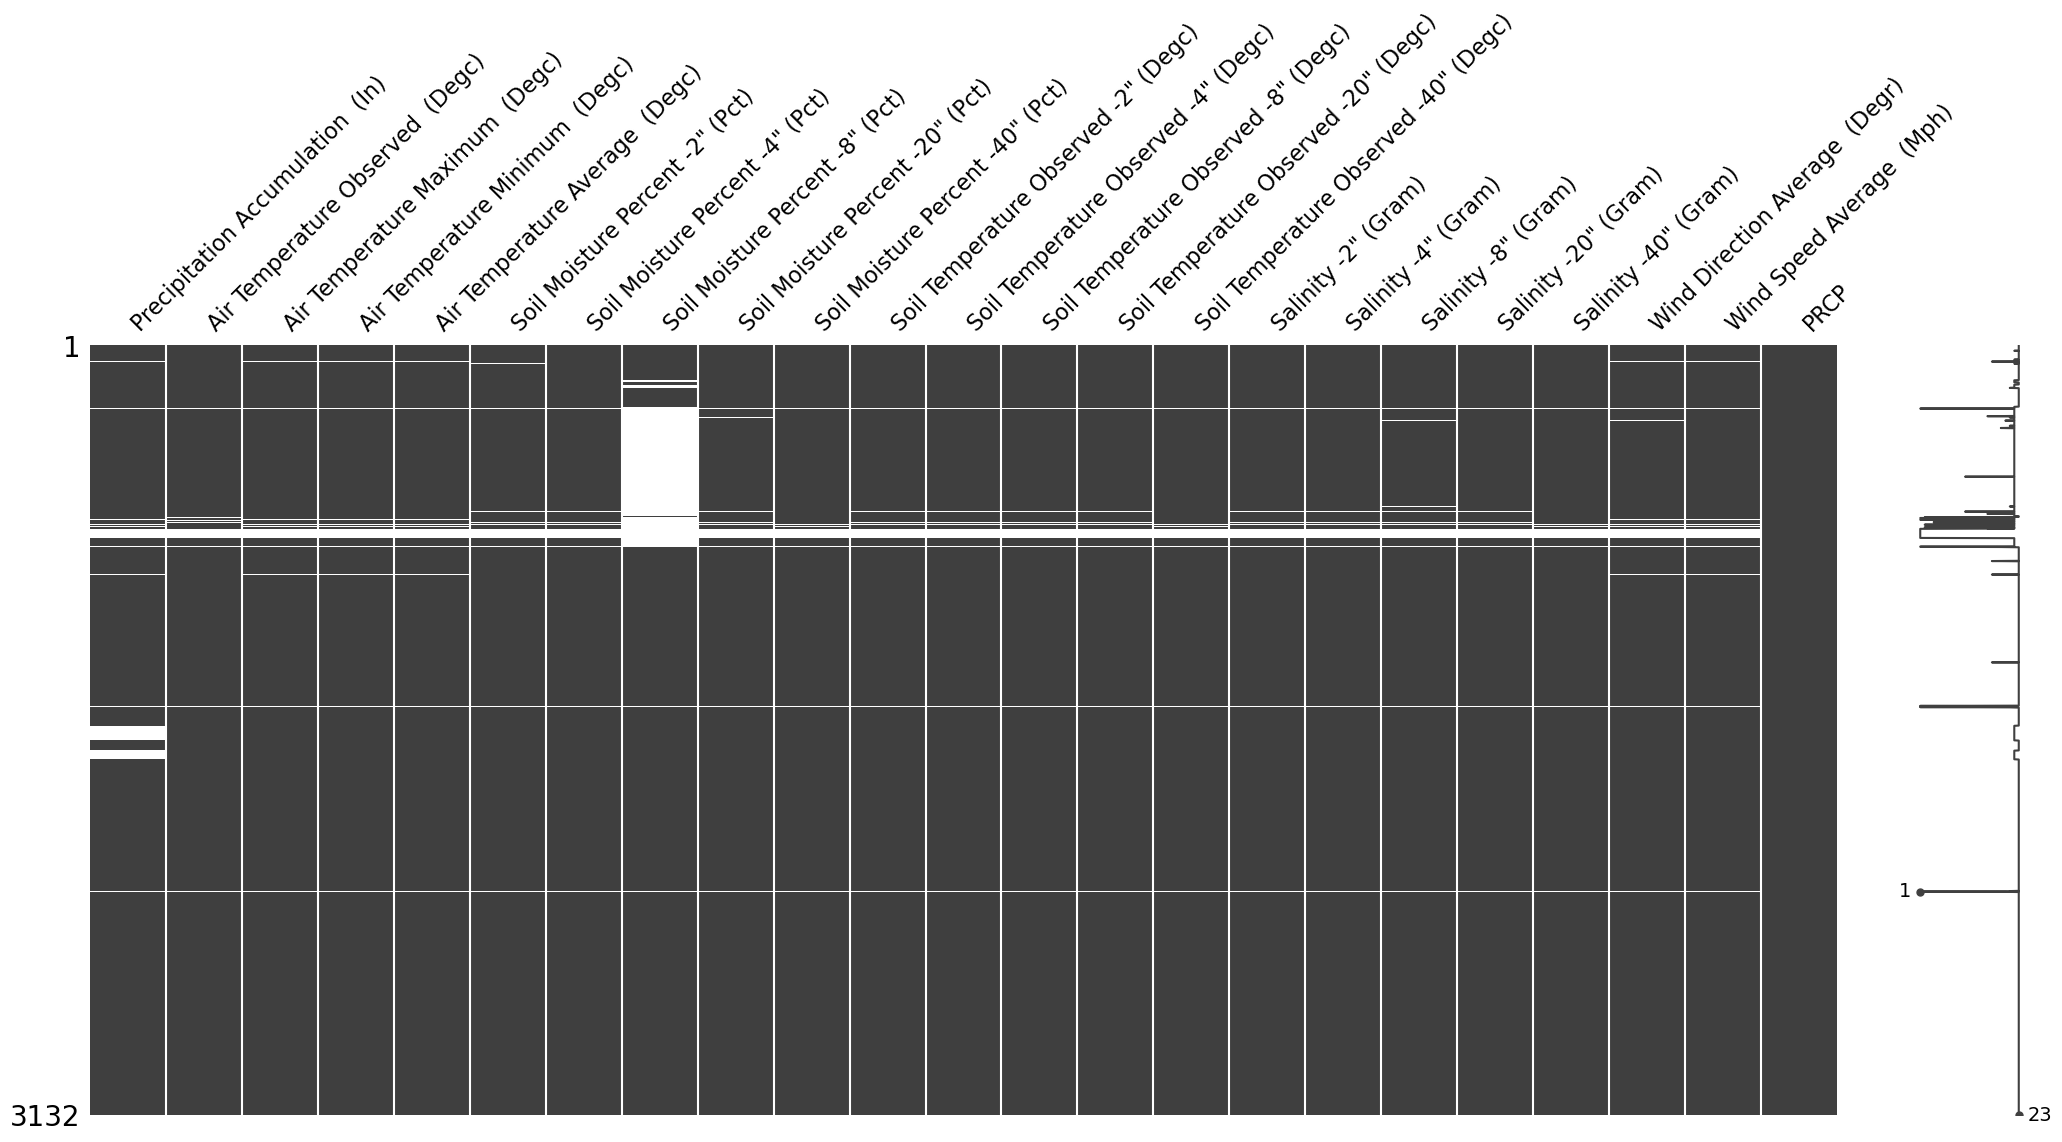

In [52]:
# We do neet to worry about Battery power of the SCAN system nor the site id let's drop those columns
labeled_df.drop(['Site Id', 'Battery  (Volt)', 'Battery  (Volt)','Real Dielectric Constant -2" (Unit)','Real Dielectric Constant -4" (Unit)','Real Dielectric Constant -8" (Unit)', 'Real Dielectric Constant -20" (Unit)','Real Dielectric Constant -40" (Unit)'], inplace=True, axis=1)
msno.matrix(labeled_df.drop(['year', 'day','month'], axis=1))

We are missing a good bit of data so lets think about how we are doing to handle this it looks like we have a large amount of data missing from all sensors so lets find what point in time that is occuring within

In [53]:
print('Total nans by Year')
for i in labeled_df.year.value_counts().index.sort_values():
    temp_df = labeled_df.loc[labeled_df['year'] == i, :].sort_index()
    print(f'{i} : {temp_df.isnull().sum().sum()}')

Total nans by Year
2008 : 1
2009 : 212
2010 : 415
2011 : 1123
2012 : 6
2013 : 192
2014 : 0
2015 : 27
2016 : 0
2017 : 0


<AxesSubplot:>

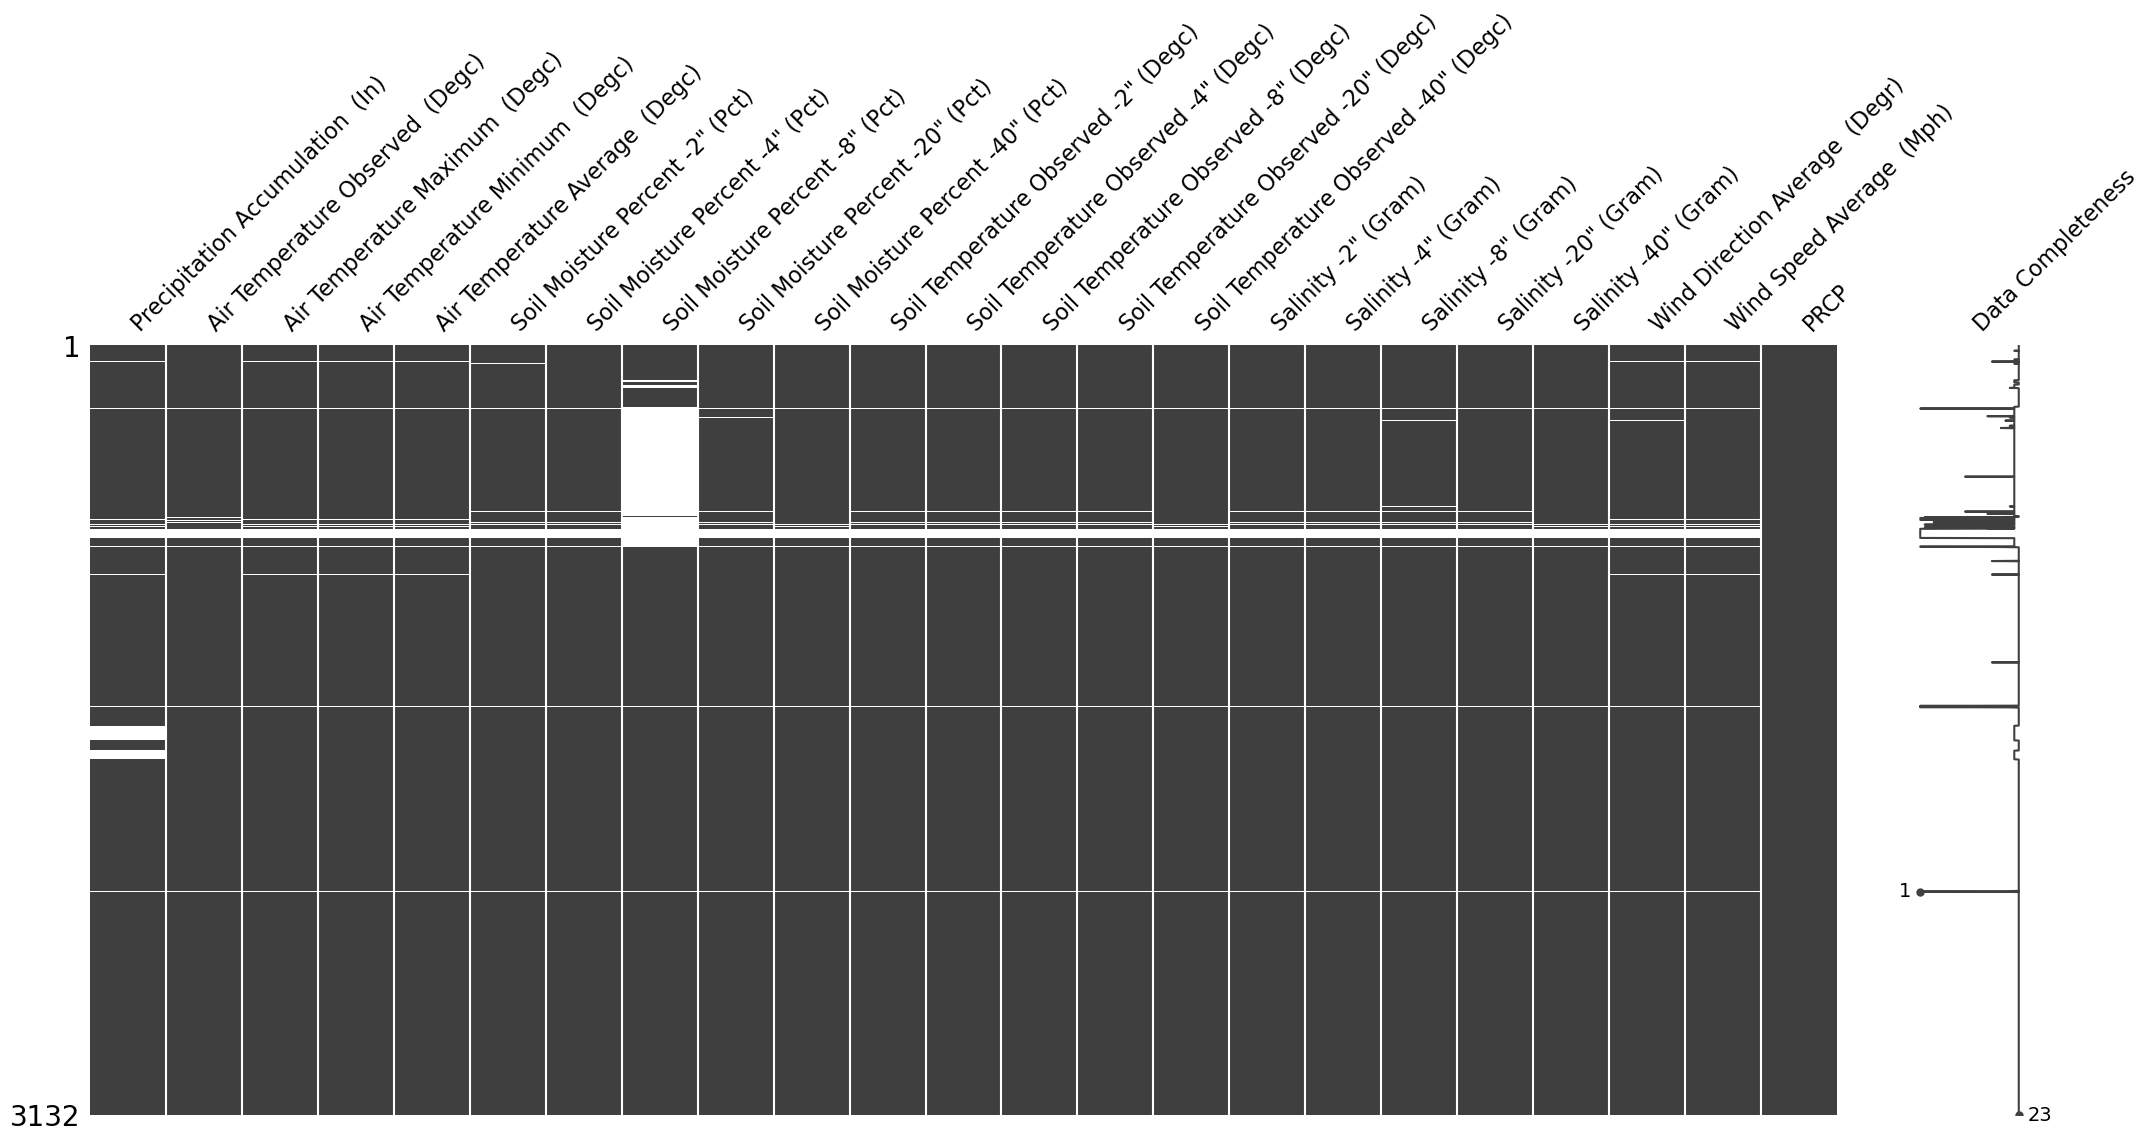

In [54]:
msno.matrix(labeled_df.drop(['day','year','month'], axis=1), labels=True)

In [55]:
df = labeled_df
df.ffill(inplace=True)
df


,Precipitation Accumulation (In),Air Temperature Observed (Degc),Air Temperature Maximum (Degc),Air Temperature Minimum (Degc),Air Temperature Average (Degc),"Soil Moisture Percent -2"" (Pct)","Soil Moisture Percent -4"" (Pct)","Soil Moisture Percent -8"" (Pct)","Soil Moisture Percent -20"" (Pct)","Soil Moisture Percent -40"" (Pct)",...,"Salinity -4"" (Gram)","Salinity -8"" (Gram)","Salinity -20"" (Gram)","Salinity -40"" (Gram)",Wind Direction Average (Degr),Wind Speed Average (Mph),PRCP,year,month,day
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-01,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,12.3,24.0,...,0.1,0.1,0.1,0.1,63.0,2.8,0.0,2008,11,01
2008-11-02,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,12.2,24.1,...,0.1,0.1,0.1,0.1,92.0,2.1,0.0,2008,11,02
2008-11-03,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,12.2,23.9,...,0.0,0.1,0.1,0.1,98.0,2.0,0.0,2008,11,03
2008-11-04,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,11.7,23.9,...,0.0,0.1,0.1,0.1,82.0,5.3,0.0,2008,11,04
2008-11-05,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,11.9,23.7,...,0.0,0.1,0.1,0.1,74.0,4.5,0.0,2008,11,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,9.2,24.5,...,0.1,0.1,0.1,0.2,345.0,3.7,0.0,2017,11,27
2017-11-28,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,8.8,24.7,...,0.1,0.1,0.1,0.1,75.0,1.8,0.0,2017,11,28
2017-11-29,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,9.2,24.6,...,0.1,0.1,0.1,0.1,83.0,2.8,0.0,2017,11,29


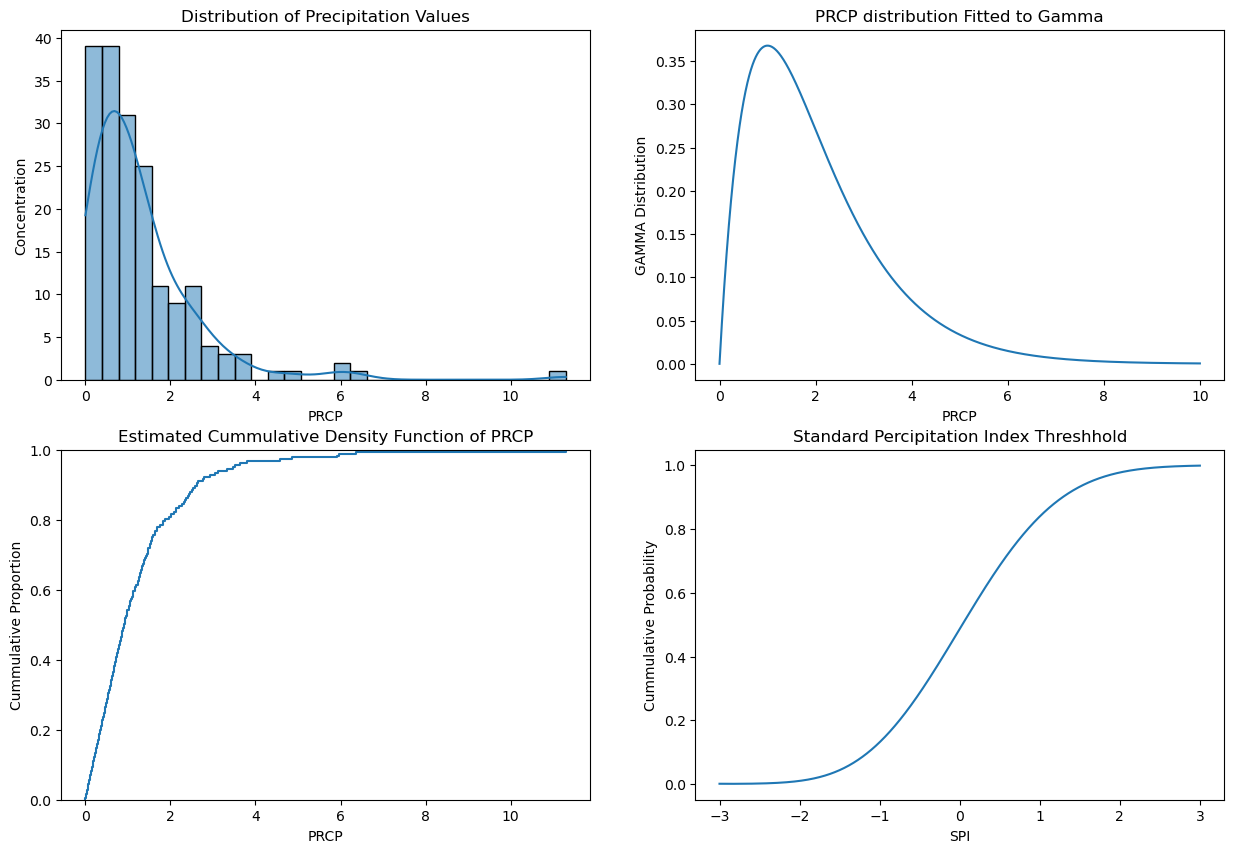

In [56]:
dFrame, fig, ax = get_spi_from_precip_col(df, 'PRCP')

In [57]:
dFrame

,Precipitation Accumulation (In),Air Temperature Observed (Degc),Air Temperature Maximum (Degc),Air Temperature Minimum (Degc),Air Temperature Average (Degc),"Soil Moisture Percent -2"" (Pct)","Soil Moisture Percent -4"" (Pct)","Soil Moisture Percent -8"" (Pct)","Soil Moisture Percent -20"" (Pct)","Soil Moisture Percent -40"" (Pct)",...,"Salinity -20"" (Gram)","Salinity -40"" (Gram)",Wind Direction Average (Degr),Wind Speed Average (Mph),PRCP,year,month,day,PRCP_ECDF,SPI
Date,,,,,,,,,,,,,,,,,,,,,
2008-11-01,4.90,9.6,20.4,6.2,12.0,8.8,8.5,11.0,12.3,24.0,...,0.1,0.1,63.0,2.8,0.0,2008,11,01,0.005525,-2.190902
2008-11-02,4.90,13.9,21.3,4.8,12.8,8.7,8.3,10.4,12.2,24.1,...,0.1,0.1,92.0,2.1,0.0,2008,11,02,0.005525,-2.190902
2008-11-03,4.90,14.8,22.0,9.2,15.2,8.6,8.2,10.6,12.2,23.9,...,0.1,0.1,98.0,2.0,0.0,2008,11,03,0.005525,-2.190902
2008-11-04,4.90,15.5,23.1,12.4,16.9,8.5,8.1,10.0,11.7,23.9,...,0.1,0.1,82.0,5.3,0.0,2008,11,04,0.005525,-2.190902
2008-11-05,4.90,14.4,19.0,14.4,16.6,8.5,8.0,10.0,11.9,23.7,...,0.1,0.1,74.0,4.5,0.0,2008,11,05,0.005525,-2.190902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,3.18,10.3,21.2,6.2,13.0,7.5,8.1,10.0,9.2,24.5,...,0.1,0.2,345.0,3.7,0.0,2017,11,27,0.005525,-2.190902
2017-11-28,3.18,10.4,20.8,1.1,10.5,7.1,7.9,10.5,8.8,24.7,...,0.1,0.1,75.0,1.8,0.0,2017,11,28,0.005525,-2.190902
2017-11-29,3.18,15.5,24.9,7.6,15.6,6.7,7.9,10.0,9.2,24.6,...,0.1,0.1,83.0,2.8,0.0,2017,11,29,0.005525,-2.190902


In [58]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)




def create_features(pdf, label=None):
    """
    Creates time series features from datetime index.
    """
    pdf = pdf.copy()
    pdf['date'] = pdf.index
    pdf['hour'] = pdf['date'].dt.hour
    pdf['dayofweek'] = pdf['date'].dt.dayofweek
    pdf['weekday'] = pdf['date'].dt.day_name()
    pdf['weekday'] = pdf['weekday'].astype(cat_type)
    pdf['quarter'] = pdf['date'].dt.quarter
    pdf['month'] = pdf['date'].dt.month
    pdf['year'] = pdf['date'].dt.year
    pdf['dayofyear'] = pdf['date'].dt.dayofyear
    pdf['dayofmonth'] = pdf['date'].dt.day
    pdf['weekofyear'] = pdf['date'].dt.weekofyear
    pdf['date_offset'] = (pdf.date.dt.month*100 + pdf.date.dt.day - 320)%1300

    pdf['season'] = pd.cut(pdf['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )

    pdf = pdf.rename({'Soil Moisture Percent -2" (Pct)': 'smp_2',
                'Soil Moisture Percent -4" (Pct)': 'smp_4',
                'Soil Moisture Percent -8" (Pct)': 'smp_8',
                'Soil Moisture Percent -20" (Pct)': 'smp_20',
                'Soil Moisture Percent -40" (Pct)': 'smp_40',
                'Air Temperature Average  (Degc)': 'air_temp_avg',
                'Soil Temperature Observed -2" (Degc)': 'soil_temp_2',
                'Soil Temperature Observed -4" (Degc)': 'soil_temp_4',
                'Soil Temperature Observed -8" (Degc)': 'soil_temp_8',
                'Soil Temperature Observed -20" (Degc)': 'soil_temp_20',
                'Soil Temperature Observed -40" (Degc)': 'soil_temp_40',
                'Precipitation Accumulation  (In)': 'prcp_accum',
                'Wind Direction Average  (Degr)':'wind_dir_avg',
                'Wind Speed Average  (Mph)':'wind_speed_avg'}, axis=1)
    pdf['soil_temp_avg'] = pdf[[i for i in list(pdf.columns) if 'soil_temp' in i]].agg('mean', axis=1)
    pdf['smp_avg'] = pdf[[i for i in list(pdf.columns) if 'smp' in i]].agg('mean', axis=1)



    return pdf
dFrame = create_features(dFrame)
dFrame.head(1).transpose()


Date,2008-11-01
prcp_accum,4.9
Air Temperature Observed (Degc),9.6
Air Temperature Maximum (Degc),20.4
Air Temperature Minimum (Degc),6.2
air_temp_avg,12.0
smp_2,8.8
smp_4,8.5
smp_8,11.0
smp_20,12.3
smp_40,24.0


In [59]:
dFrame.columns

Index(['prcp_accum', 'Air Temperature Observed  (Degc)',
       'Air Temperature Maximum  (Degc)', 'Air Temperature Minimum  (Degc)',
       'air_temp_avg', 'smp_2', 'smp_4', 'smp_8', 'smp_20', 'smp_40',
       'soil_temp_2', 'soil_temp_4', 'soil_temp_8', 'soil_temp_20',
       'soil_temp_40', 'Salinity -2" (Gram)', 'Salinity -4" (Gram)',
       'Salinity -8" (Gram)', 'Salinity -20" (Gram)', 'Salinity -40" (Gram)',
       'wind_dir_avg', 'wind_speed_avg', 'PRCP', 'year', 'month', 'day',
       'PRCP_ECDF', 'SPI', 'date', 'hour', 'dayofweek', 'weekday', 'quarter',
       'dayofyear', 'dayofmonth', 'weekofyear', 'date_offset', 'season',
       'soil_temp_avg', 'smp_avg'],
      dtype='object')

In [60]:
dFrame = dFrame.drop(['Air Temperature Maximum  (Degc)','Air Temperature Observed  (Degc)','Air Temperature Minimum  (Degc)','Salinity -2" (Gram)', 'Salinity -4" (Gram)',
       'Salinity -8" (Gram)', 'Salinity -20" (Gram)', 'Salinity -40" (Gram)','PRCP_ECDF'], axis=1)

In [63]:
dFrame.dtypes

prcp_accum               float64
air_temp_avg             float64
smp_2                    float64
smp_4                    float64
smp_8                    float64
smp_20                   float64
smp_40                   float64
soil_temp_2              float64
soil_temp_4              float64
soil_temp_8              float64
soil_temp_20             float64
soil_temp_40             float64
wind_dir_avg             float64
wind_speed_avg           float64
PRCP                     float64
year                       int64
month                      int64
day                       object
SPI                      float64
date              datetime64[ns]
hour                       int64
dayofweek                  int64
weekday                 category
quarter                    int64
dayofyear                  int64
dayofmonth                 int64
weekofyear                 int64
date_offset                int64
season                  category
soil_temp_avg            float64
smp_avg   

In [62]:
dFrame.to_parquet("./Data/Tifton_SPI_FE.parquet")